# Power Outage Data Analysis

The goal of this ipython notebook is to determine what trends exist in the historical records of large power outages in the United States. The dataset is obtained from the Office of Electricity Delivery and Energy Reliability, part of the Department of Energy. 

The dataset is very messy and I will spend a bulk of the time cleaning the dataset and getting it ready for analysis. This would involve doing the following:
1. Cleaning the date and time columns. The format of these columns are not uniform, hence it requires a bit of work to clean
2. Cleaning the number of customers affected and the amount of power lost columns: These two columns contain a mixture of strings and numbers. Care must be taken to not lose any information.
3. Perform some exploratory data analysis 





In [1]:
#import a number of useful modules
import pandas as pd
import numpy as np

import ssl
import datetime
import re

import statsmodels.api as sm
from sklearn import linear_model
from sklearn import tree
from sklearn.cross_validation import *
from sklearn import metrics
#from sklearn import svm
from sklearn import ensemble

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn 
%matplotlib inline
plt.style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = (12.0, 6.0)

ssl._create_default_https_context = ssl._create_unverified_context #This is used to disable HTTPS certificate validation

## Blackout Data
By regulation, electric power utilities must report outages that disrupt more than 300MW or 50,000 customers.
I will be analyzing data from the years 2000 till 2014.

In [2]:
data_14= pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=62',skiprows=[0]) #row 0 useless info
data_13= pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=41',skiprows=[0])
data_12= pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=31', skiprows=[0])
data_11 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=22', skiprows=[0])
data_10 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=11',skiprows=[0])
data_09 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=10',skiprows=[0])
data_08 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=9',skiprows=[0,1])
data_07 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=8',skiprows=[0])
data_06 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=7',skiprows=[0])
data_05 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=6',skiprows=[0])
data_04= pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=5',skiprows=[0])
data_03 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=4',skiprows=[0])
data_02 = pd.read_excel('https://www.oe.netl.doe.gov/download.aspx?type=OE417XLS&ID=3',skiprows=[0,1])
data_00 = pd.read_csv('/Users/oladipoositelu/Desktop/2000_2001blackouts.csv')

WARNING *** file size (91844) not 512 + multiple of sector size (512)
WARNING *** file size (81604) not 512 + multiple of sector size (512)
WARNING *** file size (83140) not 512 + multiple of sector size (512)
WARNING *** file size (96964) not 512 + multiple of sector size (512)
WARNING *** file size (50884) not 512 + multiple of sector size (512)
WARNING *** file size (52420) not 512 + multiple of sector size (512)
WARNING *** file size (59587) not 512 + multiple of sector size (512)
WARNING *** file size (38595) not 512 + multiple of sector size (512)
WARNING *** file size (42179) not 512 + multiple of sector size (512)
WARNING *** file size (44227) not 512 + multiple of sector size (512)
WARNING *** file size (44227) not 512 + multiple of sector size (512)
WARNING *** file size (40131) not 512 + multiple of sector size (512)
WARNING *** file size (24259) not 512 + multiple of sector size (512)


## Quick note about the datasets
I took a quick glance through the data files and it appears that data from 2002 to 2010 have similarly named columns. Data from 2011 to 2014 have similarly named columns as well. Therefore, I will merge data from 2002 to 2010 (call this merge data_1). I will also merge data from 2011 to 2014 (call this merge data_2). 

I will do the following:
1. Change names of columns to make things easier to read and work with
2. clean the datasets up
3. Merge the datasets


In [3]:
data_00.rename(columns={'loss':'demand_loss','time':'event_time','time.1':'restoration_time','area':'Area Affected'}, inplace=True)

In [4]:
data_02.rename(columns={'Area':'Area Affected','Restoration Time':'Restoration',
                       'Number of Customers Affected':'Number of Customers Affected 1'},inplace=True)
data_07.rename(columns={'Number of Customers Affected 1[1]':'Number of Customers Affected 1'},inplace=True)


### Merge the datasets. 


In [5]:
data_1=pd.concat([data_02,data_03,data_04,data_05,data_06,data_07,data_08,data_09,data_10],ignore_index=True)
data_2=pd.concat([data_11,data_12,data_13,data_14],ignore_index=True)


Let's observe the shape (rows,columns) of the two datasets.

In [6]:
print "The shape of data_1:",data_1.shape
print "The shape of data_2:",data_2.shape
print "The shape of data_00:", data_00.shape

The shape of data_1: (1081, 8)
The shape of data_2: (959, 10)
The shape of data_00: (45, 10)


#### Rename some columns in data_1

In [7]:
data_1.rename(columns={'Date': 'event_date', 'Time': 'event_time','Number of Customers Affected 1':'customers',
                      'Type of Disturbance':'type','Loss (megawatts)':'demand_loss','Restoration':'restoration_date'}, inplace=True)



#### Rename some columns in data_2

In [8]:
data_2.rename(columns= {'Date Event Began': 'event_date','Time Event Began':'event_time', 
                        'Respondent': 'utility', 'Number of Customers Affected': 'customers',
                        'Date of Restoration': 'restoration_date','Demand Loss (MW)': 'demand_loss',
                        'Event Type': 'type', 'NERC Region': 'powerpool','Time of Restoration':'restoration_time'}, inplace= True)


## Observe the first 3 rows of each of the data sets

In [9]:
data_1.head(3) #see what the first 3 rows look like

,event_date,Utility/Power Pool (NERC Region),event_time,Area Affected,type,demand_loss,customers,restoration_date
0,January,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-30 00:00:00,Oklahoma Gas & Electric,06:00:00,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
2,NaN,(SPP),NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data_2.head(3)

,event_date,event_time,restoration_date,restoration_time,utility,Area Affected,powerpool,type,demand_loss,customers
0,January,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-11 00:00:00,23:08:00,2011-01-11 00:00:00,23:08:00,New Athens Generating Co. LLC,"Athens, New York",NPCC,Electrical Fault at Generator,0,0
2,2011-01-12 00:00:00,06:00:00,2011-01-12 00:00:00,14:00:00,National Grid,Massachusetts,NPCC,Winter Storm,NaN,80000


In [11]:
data_00.head(3)

,event_date,utility,powerpool,event_time,Area Affected,type,demand_loss,customers,restoration_date,restoration_time
0,1/17/2001,Calif. Indep. System Operator,(WSCC),1:45 a.m.,California,Firm load interruption,500,NaN,1/18/2001,12:00 p.m.
1,1/20/2001,Calif. Indep. System Operator,(WSCC),8:15 a.m.,California,Firm load interruption,300,NaN,1/21/2001,2:50 p.m.
2,3/6/2001,New England,ISO,9:17 a.m.,Boston & Northeast Massachusetts,Interruption of Firm Power,340,130000,3/6/2001,11:00 a.m.


### check for empty rows
A blackout report is associated with a utility. If a row does not contain information on the affected utility company, then that row is likely empty or doesn't contain useful information. 

In [12]:
print "Number of missing rows in utility column for data_1:",data_1['Utility/Power Pool (NERC Region)'].isnull().sum()
print "Number of missing rows in utility column for data_2:",data_2.utility.isnull().sum()
print "Number of missing rows in utility column for data_00:", data_00.utility.isnull().sum()


Number of missing rows in utility column for data_1: 232
Number of missing rows in utility column for data_2: 61
Number of missing rows in utility column for data_00: 0


In [13]:
data_1=data_1.dropna(subset=['Utility/Power Pool (NERC Region)','event_date'])
data_2=data_2.dropna(subset=['utility','event_date']) 

Looking at data_1, the utility and nerc region information are lumped into one column. I need to split that column into two. First, I would like to get an idea of what type of values are in this column


In [14]:
data_1['Utility/Power Pool (NERC Region)'].head(10)

1                       Oklahoma Gas & Electric 
3                Kansas City Power & Light (SPP)
4                  Missouri Public Service (SPP)
6                San Diego Gas & Electric (WSCC)
8                    Consumers Energy Co. (ECAR)
10                 Arizona Public Service (WSCC)
13                 Pacific Gas & Electric (WSCC)
14                 Pacific Gas & Electric (WSCC)
15    Consolidated Edison Co. of New York (NPCC)
17             Central Illinois Light Co. (MAIN)
Name: Utility/Power Pool (NERC Region), dtype: object

The nerc region is in parenthesis, hence I will split the strings in this column based on the left hand parenthesis. 

In [15]:
nerc = data_1['Utility/Power Pool (NERC Region)'].str.split('(',expand= True)
data_1['utility']=nerc[0]
data_1['powerpool']= nerc[1].str.replace(')','') #get rid of the right sided parenthesis

In [16]:
data_1['utility']=data_1.utility.str.strip() #remove white spaces from the left and right
data_1['powerpool']=data_1.powerpool.str.strip()

There are a few noticeable meaningless values that I have observed from simply looking through the utility column. I will remove them from the sample

In [17]:
data_1=data_1[data_1['Utility/Power Pool (NERC Region)']!='Utility/Power Pool (NERC Region)']
data_1=data_1[data_1['Utility/Power Pool (NERC Region)']!='Major Disturbances and Unusual Occurrences,  January through December 2005']
data_1=data_1[data_1['Utility/Power Pool (NERC Region)']!='Major Disturbances and Unusual Occurrences,  January through December 2004']
data_1=data_1[data_1['Utility/Power Pool (NERC Region)']!='Major Disturbances and Unusual Occurrences, 2003']
#I may still have some other meaningless rows after these changes. May have to look at the end to make sure
print "After cleaning out missing data and meaningless rows, the shape is:", data_1.shape

After cleaning out missing data and meaningless rows, the shape is: (800, 10)


##  Deal with dates

The next thing I need to do is parse the date variable. The date variable has some issues with certain observations that need to be corrected before the entire column is a datetime.datetime column. First I need to create a few functions.

In [18]:
# check if there are any none datetime.datetime rows in a column
def check_datetime(data,date):
    bb=[]
    for row in data[date]:
        if type(row) is datetime.datetime:
            bb.append(0)
        else: 
            bb.append(row)
    return set(bb)
 

In [19]:
def convert_date(date): ## convert to datetime
    date=pd.to_datetime(date,errors='coerce')
    return date


In [20]:
check_datetime(data_1,'event_date')

{0, u' 1/19/05', u'7/01//05'}

##### data_1.event_date has two values that are not datetime that need to be corrected.

In [21]:
data_1=data_1.reset_index()

In [22]:
date=[] #this empty list will hold the values

for i in range(len(data_1)):
    if data_1['event_date'].str.contains('7/01//05')[i]==True:
        date.append(datetime.datetime.strptime('7/01/2005','%m/%d/%Y'))
    elif data_1['event_date'].str.contains(u' 1/19/05')[i]==True:
        date.append(datetime.datetime.strptime(u'1/19/2005','%m/%d/%Y'))   
    else:
        date.append(data_1['event_date'][i])
data_1['event_date']=date    

        

## Handle time variable

In [23]:
data_1.event_time.unique()

array([datetime.time(6, 0), u'Evening', datetime.time(16, 0),
       datetime.time(10, 48), datetime.time(0, 0), datetime.time(15, 0),
       datetime.time(12, 27), datetime.time(11, 51), datetime.time(12, 40),
       datetime.time(12, 43), datetime.time(8, 23), datetime.time(3, 41),
       datetime.time(14, 9), datetime.time(3, 33), datetime.time(22, 0),
       datetime.time(15, 48), datetime.time(18, 30), datetime.time(13, 9),
       datetime.time(11, 0), datetime.time(17, 0), datetime.time(10, 0),
       u'2:00 p.m.', u'11:32 a.m.', u'7:00 p.m.', u'3:11 a.m.',
       u'11:00 a.m.', u'3:41 p.m.', u'5:00 p.m.', u'8:00 p.m.',
       u'2:52 a.m.', u'3:12 p.m.', u'1:00 p.m.', u'3:15 p.m.',
       u'1:54 p.m.', u'6:00 a.m.', u'9:00 a.m.', u'11:41 p.m.',
       u'3:00 a.m.', u'4:00 a.m.', u'5:14 p.m.', u'8:24 a.m.',
       u'5:15 p.m.', u'6:55 p.m.', u'Approximately 3:00 p.m.',
       u'4:09 p.m.', u'4:10 p.m.', u'4:11 p.m.', u'4:00 p.m.',
       u'4:22 p.m.', u'5:19 a.m.', u'8:20 a.m.', u

Fix the individual date rows that have problems

In [24]:
time=[]
for i in range(len(data_1)): 
    if data_1.event_time.str.contains('midnight')[i]  == True:
        time.append(data_1['event_time'].str.replace('midnight','12:00 am')[i])
    elif data_1['event_time'].str.contains('Midnight')[i] == True:
        time.append(data_1['event_time'].str.replace('Midnight','12:00 am')[i])
    elif data_1['event_time'].str.contains('Approximately 3:00 p.m.')[i] == True:
        time.append(data_1['event_time'].str.replace('Approximately 3:00 p.m.','3:00pm')[i])
    elif data_1['event_time'].str.contains('Ongoing')[i] == True:
        time.append(data_1['event_time'].str.replace('Ongoing','')[i])
    elif data_1['event_time'].str.contains('12:00 noon')[i] == True:
        time.append(data_1['event_time'].str.replace('12:00 noon','12:00pm')[i])
    elif data_1['event_time'].str.contains('Evening')[i] == True:
        time.append(data_1['event_time'].str.replace('Evening','6:00pm')[i])
    elif data_1['event_time'].str.contains('5:78 p.m.')[i] == True:
        time.append(data_1['event_time'].str.replace('5:78 p.m.','5:00pm')[i]) ## come back to this
    else:
        time.append(data_1['event_time'][i])
data_1['event_time']=time


In [25]:
data_1['event_time']=[str(x) if type(x) is unicode else x for x in data_1.event_time] # change unicode to string
data_1['event_time']=[x.replace('.','') if type(x) is str else x for x in data_1.event_time] # remove the . in a.m. or p.m.
data_1['event_time']=[x.replace(' ','') if type(x) is str else x for x in data_1.event_time] #remove all spaces as well

event_time variable is a mixture of datetime.time and strings. I want to convert the strings into datetime format

In [26]:
dd=[]
for row in data_1['event_time']:
    if type(row) is str and row !='':
        try: 
            dd.append(datetime.datetime.strptime(row, "%I:%M%p").time())
        except ValueError, v:
            
            if len(v.args) > 0 and v.args[0].startswith('unconverted data remains: '):
                row = row[:-(len(v.args[0])-26)]
                row = datetime.datetime.strptime(row,"%I:%M%p").time()
            else:
                raise v
    else:
        dd.append(row)
        

In [27]:
data_1['event_time']=dd

In [28]:
def convert_time(time): #make the time variable appear as time delta
    if type(time) is datetime.datetime or type(time) is datetime.time:
        time=datetime.timedelta(hours=time.hour,minutes=time.minute)
    else:
        time=pd.to_datetime(time,errors='coerce')
    return time
    

In [29]:
data_1['event_time']=data_1.event_time.apply(convert_time)

In [30]:
def convert_datetime(data,date,time):
    bb=[]
    for i in range(len(data)):
        if data[date].dt.hour[i]==0 and data[date].dt.minute[i]==0 and data[date].dt.second[i]==0:
            bb.append(data[date][i]+data[time][i]) 
        else:
            bb.append(data[date][i])
    return bb
    

In [31]:
data_1['event_datetime']=convert_datetime(data_1,'event_date','event_time')

Now I will move on to the restoration_date variable 

In [32]:
print "The number of missing data in restoration_date:", data_1.restoration_date.isnull().sum()

The number of missing data in restoration_date: 1


In [33]:
data_1.restoration_date.unique()

array([datetime.datetime(2002, 2, 7, 12, 0), nan,
       datetime.datetime(2002, 2, 10, 21, 0),
       datetime.datetime(2002, 2, 27, 11, 35),
       datetime.datetime(2002, 3, 11, 12, 0),
       datetime.datetime(2002, 4, 9, 0, 0),
       datetime.datetime(2002, 7, 9, 19, 54),
       datetime.datetime(2002, 7, 19, 16, 30),
       datetime.datetime(2002, 7, 20, 20, 12),
       datetime.datetime(2002, 8, 2, 18, 36),
       datetime.datetime(2002, 8, 9, 12, 13),
       datetime.datetime(2002, 8, 25, 9, 17),
       datetime.datetime(2002, 8, 28, 15, 38),
       datetime.datetime(2002, 10, 12, 0, 0), u'Noon November 10',
       u'Unknown', datetime.datetime(2002, 11, 21, 8, 0),
       datetime.datetime(2002, 12, 9, 22, 30),
       datetime.datetime(2002, 12, 13, 22, 0),
       datetime.datetime(2002, 12, 19, 16, 0),
       datetime.datetime(2002, 12, 21, 17, 0),
       datetime.datetime(2002, 12, 26, 5, 0),
       datetime.datetime(2002, 12, 27, 8, 30), u'1/26/03, 2:00 a.m.',
       u'3/01

In [34]:
data_1['event_year']= data_1['event_date'].dt.year

There are different formats that the individual rows in restoration_date column take. My solution is to force the rows to convert into datetime and then observe the rows that were not converted successfully. I can then make changes to those rows and then convert them to datetime.datetime.

In [35]:
data_1['rest_date']=pd.to_datetime(data_1['restoration_date'],errors='coerce') #coerce rows to be converted
data_1['rest_year']=data_1['event_year']
print "After parsing the rest_date, how many missing values are there?", data_1.rest_date.isnull().sum()


After parsing the rest_date, how many missing values are there? 22


Clearly parsing the dates through coercion led to missing values. Let's look at these rows and see why they didn't parse

Some of these rows have noon or midnight in them. I can easily replace them with p.m and a.m. respectively. 

In [36]:
rest=[]
for i in range(len(data_1)): 
    if data_1.restoration_date.str.contains('12:00 midnight')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('12:00 midnight','12:00 a.m.')[i])
    elif data_1['restoration_date'].str.contains('12:00 noon')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('12:00 noon','12:00 p.m.')[i])
    elif data_1['restoration_date'].str.contains('Noon')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('Noon','12:00 p.m.')[i]) 
    elif data_1['restoration_date'].str.contains('12 noon')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('12 noon','12:00 p.m.')[i])
    elif data_1['restoration_date'].str.contains('9/08/05,12:01 a.m.')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('9/08/05,12:01 a.m.','9/08/05, 12:01 a.m.')[i])
    elif data_1['restoration_date'].str.contains('10/18/05, 3: 37 p.m.')[i] == True:
        rest.append(data_1['restoration_date'].str.replace('10/18/05, 3: 37 p.m.','10/18/05, 3:37 p.m.')[i])
    else:
        rest.append(data_1['restoration_date'][i])
data_1['rest_date']=rest


In [37]:
data_1['rest_date']=pd.to_datetime(data_1.rest_date,errors='coerce')


After correcting the issues, the only rows that did not convert are those labeled ongoing or unknown (A total of 12 rows out of 800 rows).

While converting the dates, some rows ended up with year 2016 because the year wasn't explicity accounted for in the dataset. These dates need to be changed to the actual dates. 

I also have to account for cases(those with year 2016) where the blackout happens at the end of the year(december) and recovery is completed at the beginning of the next year

In [38]:
rest_datetime=[]
for i in range(len(data_1)): 
    if data_1['rest_date'].dt.year[i]==2016 and data_1['event_date'].dt.month[i]<12:
        rest_datetime.append(data_1['rest_date'][i].replace(year = data_1['event_year'][i]))
    elif data_1['rest_date'].dt.year[i]==2016 and data_1['event_date'].dt.month[i]==12 and data_1['rest_date'].dt.month[i]==1:
        rest_datetime.append(data_1['rest_date'][i].replace(year=data_1['event_year'][i] + 1 ))
    elif data_1['rest_date'].dt.year[i]==2016 and data_1['event_date'].dt.month[i]==12 and data_1['rest_date'].dt.month[i]==12:
        rest_datetime.append(data_1['rest_date'][i].replace(year=data_1['event_year'][i]))
    else:
        rest_datetime.append(data_1['rest_date'][i])
data_1['restoration_datetime']=rest_datetime

In [39]:
data_1['blackout_duration']=data_1.restoration_datetime-data_1.event_datetime #this is how long it took to restore power fully


## Let's look at data_2 (2011 to 2014) and clean it up as well.

In [40]:
check_datetime(data_2,'event_date')

{0, u'Date Event Began'}

In [41]:
data_2=data_2[data_2.event_date != 'Date Event Began']

In [42]:
data_2=data_2.reset_index()

In [43]:
data_2['event_date']=data_2.event_date.apply(convert_date)

In [44]:
data_2['event_time']=data_2['event_time'].apply(convert_time)

In [45]:
data_2['event_datetime']=convert_datetime(data_2,'event_date','event_time')

In [46]:
check_datetime(data_2,'restoration_date')

{0, u'Ongoing', u'Unknown'}

The only non datetime rows in restoration_date variable are 'onging' and 'unknown'. We can change those to missing data.

In [47]:
data_2['restoration_date']=data_2.restoration_date.apply(convert_date)

In [48]:
data_2['restoration_time']=data_2.restoration_time.apply(convert_time)

In [49]:
data_2['restoration_datetime']=convert_datetime(data_2,'restoration_date','restoration_time')

In [50]:
np.sort(data_2.restoration_datetime.dt.year.unique() )

array([ 2001.,  2011.,  2012.,  2013.,  2014.,  2015.,  2077.,    nan])

Because the dataset is from 2011 to 2014, it is very obvious that the values 2001 and 2077 have no place in the data. 2015 could occur if the blackout happended late in 2014 and recovery wasn't concluded untill 2015

In [51]:
data_2[(data_2.restoration_datetime.dt.year==2001) | (data_2.restoration_datetime.dt.year==2077)]

,index,event_date,event_time,restoration_date,restoration_time,utility,Area Affected,powerpool,type,demand_loss,customers,event_datetime,restoration_datetime
41,44,2011-03-08,08:00:00,2001-03-18,09:00:00,AES Somerset,Western New York,NPCC,Fuel Supply Deficiency (Coal),676,UNK,2011-03-08 08:00:00,2001-03-18 09:00:00
219,227,2011-08-27,23:05:00,2077-08-29,15:30:00,Pepco,District of Columbia; Maryland,RFC,Severe Weather,NaN,220000,2011-08-27 23:05:00,2077-08-29 15:30:00


In [52]:
#replace 2077 and 2001 with 2011
restoration_date=[]
for i in range(len(data_2)):
    if data_2['restoration_datetime'].dt.year[i]==2077 or data_2['restoration_datetime'].dt.year[i]==2001:
        restoration_date.append(data_2.restoration_datetime[i].replace(year=2011))
    else:
        restoration_date.append(data_2.restoration_datetime[i])
data_2['restoration_datetime']=restoration_date

In [53]:
data_2['blackout_duration'] = data_2.restoration_datetime-data_2.event_datetime

## Look at data_00 (2000 and 2001 data)

In [54]:
check_datetime(data_00,'event_date')

{'1/17/2001',
 '1/20/2001',
 '1/23/2000',
 '1/24/2000',
 '1/29/2000',
 '12/16/2000',
 '3/14/2000',
 '3/14/2001',
 '3/18/2000',
 '3/19/2001',
 '3/20/2001',
 '3/6/2001',
 '4/1/2000',
 '4/20/2000',
 '5/18/2000',
 '5/2/2000',
 '5/21/2000',
 '5/24/2000',
 '5/25/2000',
 '5/31/2000',
 '5/7/2001',
 '5/8/2000',
 '5/8/2001',
 '5/9/2000',
 '6/14/2000',
 '6/25/2001',
 '6/28/2000',
 '6/6/2001',
 '6/8/2001',
 '7/20/2000',
 '7/3/2000',
 '8/10/2000',
 '8/18/2000',
 '8/28/2000',
 '8/6/2000',
 '8/9/2000',
 '8/9/2001'}

All the dates need to be converted to datetime

In [55]:
data_00['event_date']=data_00.event_date.apply(convert_date)
data_00['restoration_date']=data_00.restoration_date.apply(convert_date)

In [56]:
data_00['event_time'].unique()

array(['1:45 a.m.', '8:15 a.m.', '9:17 a.m.', '3:00 p.m.', '11:50 a.m.',
       '11:46 a.m.', '4:45 p.m.', '3:10 p.m.', '3:12 p.m.', '4:22 p.m.',
       '7:00 p.m.', '1:25 p.m.', '3:11 p.m.', '8:00 a.m.', '10:00 p.m.',
       '9:06 p.m.', '4:00 p.m.', '7:08 p.m.', nan, '4:00 a.m.',
       '11:39 a.m.', '6:00 p.m.', '10:15 a.m.', '10:00 a.m.', '1:15 a.m.',
       '1:13 p.m.', '3:45 p.m.', '3:54 p.m.', '5:52 p.m.', '6:30 p.m.',
       '9:30 p.m.', '11:00 p.m.', '11:36 a.m.'], dtype=object)

In [57]:
data_00['ET']=data_00['event_time'].apply(convert_time).dt.time.apply(convert_time)

In [58]:
data_00['RT']=data_00['restoration_time'].apply(convert_time).dt.time.apply(convert_time)

In [59]:
data_00['event_datetime']=convert_datetime(data_00,'event_date','ET')

In [60]:
data_00['restoration_datetime']=convert_datetime(data_00,'restoration_date','RT')

In [61]:
data_00['blackout_duration']=data_00.restoration_datetime-data_00.event_datetime

### Merge data sets

In [62]:
data=pd.concat([data_1,data_2,data_00],ignore_index=True)

In [63]:
data.shape

(1736, 20)

In [64]:
data['OutageDays']=data.blackout_duration.astype('timedelta64[D]') #This is the number of days without power

In [65]:
data['OutageinSeconds']=(pd.to_timedelta(data.blackout_duration).dt.days*60*60*24)+ pd.to_timedelta(data.blackout_duration,unit='s').dt.seconds

In [66]:
data['OutageinHours']=data['OutageinSeconds']/3600.

## Handle number of customers affected column

In [67]:
dd=[type(row) for row in data['customers']] # I want to see what type of data exists in this column

In [68]:
set(dd)

{float, int, str, unicode}

We have a combination of float, integer, strings and unicode. However, this column needs to be numeric

In [69]:
data.customers.unique()

array([1881134, 270000, 95000, 255000, 190000, 0, u'1 PG&E', 63500, 53565,
       25000, 242910, 939000, 224912, 43000, 130000, u'1.5 million',
       385000, 106000, 95630, nan, u'over 340,000', 425000, 160000, 68530,
       139000, u'102,842 (Georgia)', 192000, 2, 179299, 47000, 1, 52000,
       131000, 55142, 72000, 134500, 80000, 108000, 185000, 90000, 2100000,
       101000, 1203000, u'unknown', 840137, 3125350,
       u'93,000 at peak 133,000 cumulative', 153000, u'4 (industrial)',
       u'1.8 million', u'peak 320,00 9/18/03 7:00 p.m.', 650000, 237366,
       u'Under 50,000', u'Over 530,000 peak on 9/19/03',
       u'108,000 (Dist. And Trans. Combined)', 245000, 51000, 110000,
       50280, u'104,195 at 5:23 p.m. 11/13/03', 67000, 300000,
       u'200,000 (Peak)', u'6 (utilities)', 36000, 16500, 120000, 109750,
       241000, 263000, 145000, 18600, 150000, 30689, 9905,
       u'Approx. 70,000', 87456, u' PG&E', 505000, 47165, 63000, 206000,
       u'Approx. 100,000', u'85,000 at

In [70]:
data['customers']=data.customers.replace(',','',regex=True)
data['customers']=data.customers.replace('[.]','',regex=True)
data['customers']=data['customers'].replace(r'.million','00000',regex=True) #convert the million

In [71]:
def convert_to_float(data,numbers):### 
    cc=[]
    for row in data[numbers]:
        try:
            cc.append(float(row))
        except ValueError:
            try:
                if '-' in row:
                    cc.append([float(x) for x in row.split('-') if x.isdigit()][0])
                else:
                    cc.append([float(x) for x in row.split() if x.replace('.','',1).isdigit()][0]) #split rows that contain digits and strings. select first digits
            except IndexError:
                cc.append(np.nan)
    return cc
        

In [72]:
data['customers']=convert_to_float(data,'customers')

In [73]:
#data['customer_1']=data.customers.str.extract('(\d+)', expand=True) 

### Handle the demand loss column

In [74]:
data['demand_loss']=[0 if x=='None' else x for x in data['demand_loss']]


In [75]:
data['loss']=data['demand_loss'].replace(',','',regex=True) #remove any commas that may exist
data['loss']=[np.nan if type(x) is datetime.datetime else x for x in data['loss']]

In [76]:
data['loss']=convert_to_float(data,'loss')

In [77]:
(data[data.loss.isnull()].demand_loss.value_counts())

Unknown                269
UNK                     83
-                       20
--                       2
Various                  2
All                      1
unknown                  1
2011-06-08 00:00:00      1
UNK                      1
  N/A                    1
Name: demand_loss, dtype: int64

### Now the dataset is ready for analysis. I will create a new dataset that only contains the essential columns

In [78]:
important_variables=['utility','event_date','event_datetime','restoration_datetime','powerpool','loss','customers','type','OutageDays','Area Affected','OutageinSeconds','OutageinHours']

In [79]:
df=data[important_variables]

In [81]:
df.loc[:,'type'] = df['type'].str.lower().str.strip()


In [82]:
df.type.unique()

array([u'ice storm', u'interruption of firm load', u'severe weather',
       u'vandalism/', u'interruption of firm power',
       u'interruption of firm power (unit tripped)', u'fire',
       u'hurricane lily', u'winter storm', u'cable tripped',
       u'cyber threat from internet', u'winter ice storm', u'severe storm',
       u'relaying malfunction', u'vandalism', u'severe thunderstorms',
       u'interruption of firm', u'flood', u'public appeal',
       u'tropical storm bill', u'breaker failure', u'unit tripped',
       u'severe storms', u'hurricane claudette', u'breaker closed',
       u'unknown *', u'transmission  equipment', u'hurricane isabel',
       u'wild fire', u'tornado', u'wind storm', u'high winds',
       u'storm with high winds', u'major wind storm',
       u'wild fire \u2013 transmission equipment', u'fault on 138 kv line',
       u'transmission equipment', u'cable failure', u'earthquake',
       u'snow storm', u'public appeal to reduce load',
       u'lightning struck 

## create a variable that indicates what caused the blackout

In [83]:
cause=[]
for i in range(len(df)):
    if df['type'].str.contains('hurricane')[i] or df['type'].str.contains('tropical')[i]==True:
        cause.append('Hurricane')
    elif df['type'].str.contains('thunder')[i] or df['type'].str.contains('severe storm')[i]==True:
        cause.append('Thunderstorm')
    elif df['type'].str.contains('shed')[i] ==True:
        cause.append('Load Shedding')
    elif df['type'].str.contains('earthquake')[i] ==True:
        cause.append('Earthquake')
    elif df['type'].str.contains('vandal')[i] or df['type'].str.contains('attack')[i] or df['type'].str.contains('sabotage')[i] or df['type'].str.contains('cyber threat')[i] or df['type'].str.contains('cyber')[i] or df['type'].str.contains('suspicious')[i]==True:
        cause.append('Intentional Attack')
    elif df['type'].str.contains('fuel supply')[i] or df['type'].str.contains('inadequate')[i] ==True:
        cause.append('Supply Shortage')
    elif df['type'].str.contains('malfunction')[i] or df['type'].str.contains('failure')[i]==True:
        cause.append('Equipment Failure')
    elif df['type'].str.contains('tornado')[i]==True:
        cause.append('Tornadoes')
    elif df['type'].str.contains('voltage reduct')[i]==True:
        cause.append('Voltage Reduction')
    elif df['type'].str.contains('public appeal')[i]==True:
        cause.append('Public Appeal')
    elif df['type'].str.contains('severe weather')[i]==True:
        cause.append('Severe Weather')
    elif df['type'].str.contains('islanding')[i]==True:
        cause.append('Islanding')
    elif df['type'].str.contains('lightning')[i]==True:
        cause.append('Lightning')
    elif df['type'].str.contains('snow')[i] or df['type'].str.contains('winter')[i] or df['type'].str.contains('ice')[i] or df['type'].str.contains('cold')[i]==True:
        cause.append('Snow')
    elif df['type'].str.contains('wind')[i] or df['type'].str.contains('rain')[i] or df['type'].str.contains('flood')[i]==True:
        cause.append('Wind/Rain')
    elif df['type'].str.contains('firm power')[i] or df['type'].str.contains('firm load')[i] or df['type'].str.contains('firm system load loss')[i]  or df['type'].str.contains('interruption of firm')[i]==True:
        cause.append('Firm power interruption')
    elif df['type'].str.contains('fire')[i]==True:
        cause.append('fire')
    else:
        cause.append('Others')

df.loc[:,'cause']=cause


//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


I will drop events that are caused by voltage reduction as these events generally do not lead to disrupted electricity service

In [84]:
df=df[df.cause !='Voltage Reduction']

In [85]:
print "After dropping voltage reductions, the number of blackouts:", df.shape[0]

After dropping voltage reductions, the number of blackouts: 1704


### create blackout size category 

In [86]:
loss_group=[]
for row in df['loss']:
    if row>=0 and row<=299:
        loss_group.append('1-299')
    elif row>=300 and row<=999:
        loss_group.append('300-999')
    elif row>=1000 and row<=2999:
        loss_group.append('1000-2999')
    elif row>=3000 and row<=9999:
        loss_group.append('3000-9999')
    elif row>=10000 and row <=29999:
        loss_group.append('10000-29999')
    elif row>=30000:
        loss_group.append('>=30000')
    else:
        loss_group.append('unknown')
df['loss_group']=loss_group

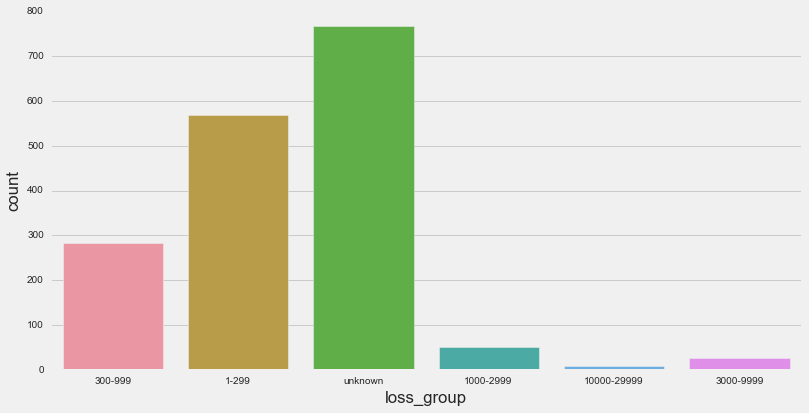

In [87]:
seaborn.countplot(df['loss_group'])

In [88]:
GT=[]
for row in df['cause']:
    if row=='Thunderstorm' or row=='Tornadoes' or row=='Hurricane' or row=='Earthquake':
        GT.append('extreme natural')
    elif row=='Public Appeal' or row =='Load Shedding' or row =='Supply Shortage':
        GT.append('Supply shortage')
    elif row =='lightning' or row =='Severe Weather' or row =='Wind/Rain' or row=='Snow':
        GT.append('non extreme weather')
    else:
        GT.append('others')

In [89]:
df['general_cause']=GT

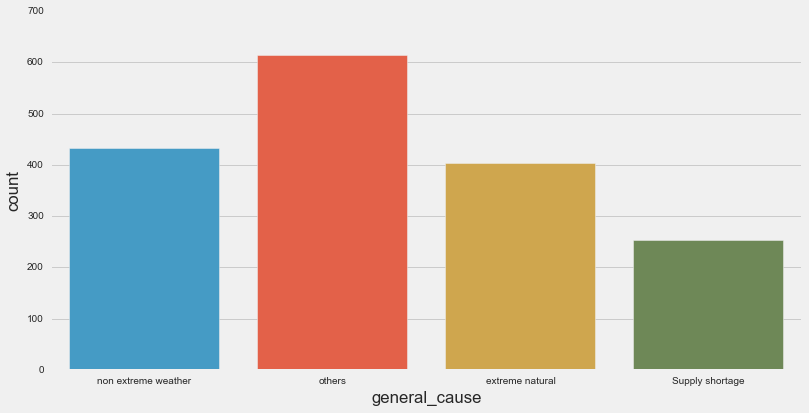

In [90]:
seaborn.countplot(df.general_cause)

In [91]:
def normalize_name(name):
    """
    Standardizes the full name of a utility. This will make name comparison easy
    
    name: full name of a utility can be in any format 
    """
    if " and" in name:
        name = name.replace(' and ',' & ')
    if "Co." in name:
        name=name.replace('Co.','Company')
    return name

In [92]:
df['utility']=df.utility.apply(normalize_name)

## How much missing data do we have?

In [93]:
print "Missing customer data:", len(df[df.customers.isnull()])
print "This is ", str(round((len(df[df.customers.isnull()])/float(len(df)) * 100), 2)) +'%' , "of available data"

Missing customer data: 450
This is  26.41% of available data


In [94]:
print "Missing loss data:", len(df[df.loss.isnull()])
print "This is ", str(round((len(df[df.loss.isnull()])/float(len(df)) * 100), 2)) +'%' , "of available data"

Missing loss data: 768
This is  45.07% of available data


In [95]:
print "Missing OutageinHours data:", len(df[df.OutageinHours.isnull()])
print "This is ", str(round((len(df[df.OutageinHours.isnull()])/float(len(df)) * 100), 2)) +'%' , "of available data"

Missing OutageinHours data: 54
This is  3.17% of available data


In [96]:
df=df.reset_index()
del df['index']

In [97]:
df.to_excel('/Users/oladipoositelu/Desktop/outagedata.xls')

## Summary
In the preceding steps, I did the following:
1. Converted Strings to numbers in situations where I could
2. Fixed date variables
3. I removed from the dataset blackouts caused by voltage reduction
4. Dropped extraneous features


# Exploratory Data Analysis
Let's look closer at the data

In [98]:
df.describe()

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,loss,customers,OutageDays,OutageinSeconds,OutageinHours
count,936.000000,1.254000e+03,1650.000000,1.650000e+03,1650.000000
mean,562.789637,1.644710e+05,1.627879,1.667808e+05,46.328010
std,1748.910499,3.385305e+05,5.037730,4.383779e+05,121.771647
min,0.000000,0.000000e+00,-1.000000,-4.860000e+04,-13.500000
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,22934.000000,4.645572e+06,131.000000,1.133868e+07,3149.633333


Looking at the descriptive statistics, two things stand out: the max amount of power lost is 22,934MW. This seems like a lot for one blackout. In addition, we also have a maximum of 131 outage days, which is very long.

I would like to look at this particular data point and also observe data for blackouts longer than 30 days.

In [99]:
df[df.OutageDays>=30].sort_values('OutageDays')

,utility,event_date,event_datetime,restoration_datetime,powerpool,loss,customers,type,OutageDays,Area Affected,OutageinSeconds,OutageinHours,cause,loss_group,general_cause
32,We Energies,2003-05-15,2003-05-15 14:00:00,2003-06-16 14:00:00,None,240.0,2.0,flood,32.0,Upper Michigan Peninsula,2764800.0,768.000000,Wind/Rain,1-299,non extreme weather
122,Salt River Project,2004-07-06,2004-07-06 06:00:00,2004-08-09 12:00:00,WECC,NaN,NaN,fire/substation multiple public appeals,34.0,"Metro Phoenix, Arizona",2959200.0,822.000000,Public Appeal,unknown,Supply shortage
123,Arizona Public Service,2004-07-06,2004-07-06 06:00:00,2004-08-09 12:00:00,WECC,NaN,NaN,fire/substation multiple public appeals,34.0,"Metro Phoenix, Arizona",2959200.0,822.000000,Public Appeal,unknown,Supply shortage
1505,"Somerset Operating Company, LLC",2014-02-07,2014-02-07 07:00:00,2014-03-21 08:00:00,NPCC,675.0,NaN,fuel supply emergency - coal,42.0,Niagara County New York,3632400.0,1009.000000,Supply Shortage,300-999,Supply shortage
598,"New Covert Generating Company, LLC",2009-03-03,2009-03-03 06:48:00,2009-04-26 06:05:00,RFC,378.0,NaN,transformer faulted/unit tripped,53.0,Southwest Michigan,4663020.0,1295.283333,Others,300-999,others
1486,We Energies,2014-01-24,2014-01-24 00:00:00,2014-04-09 11:53:00,RFC,NaN,NaN,fuel supply emergency - coal,75.0,Wisconsin,6522780.0,1811.883333,Supply Shortage,unknown,Supply shortage
1361,ITC Transmission,2013-06-21,2013-06-21 08:31:00,2013-10-30 14:09:00,MRO,NaN,NaN,suspected cyber attack,131.0,"Michigan, Iowa",11338680.0,3149.633333,Intentional Attack,unknown,others


It seems very unlikely that customers would be without power for more than a month except in rare cases involving natural disasters. However, none of the observed blackouts involved natural disasters. These values may be as a result of incorrect data entries. Need to investigate further

Another issue is that there are negative OutageHours which is quite frankly impossible. Let's investigate that.

In [100]:
df[df.OutageinHours<0].sort_values('OutageinHours')

,utility,event_date,event_datetime,restoration_datetime,powerpool,loss,customers,type,OutageDays,Area Affected,OutageinSeconds,OutageinHours,cause,loss_group,general_cause
138,Seminole Electric Cooperative,2004-08-13,2004-08-13 13:30:00,2004-08-13 00:00:00,FRCC,700.0,200000.0,hurricane charley,-1.0,"Florida counties of Collier, Hendry, Glades, H...",-48600.0,-13.500000,Hurricane,300-999,extreme natural
34,Entergy Corporation,2003-06-30,2003-06-30 13:00:00,2003-06-30 00:00:00,None,NaN,179299.0,tropical storm bill,-1.0,Coastal areas of,-46800.0,-13.000000,Hurricane,unknown,extreme natural
60,Carolina Power & Light,2003-09-18,2003-09-18 11:45:00,2003-09-18 00:00:00,SERC,1655.0,32000.0,hurricane isabel,-1.0,Eastern North Carolina,-42300.0,-11.750000,Hurricane,1000-2999,extreme natural
539,Puerto Rico Electric Power Authority,2008-09-22,2008-09-22 17:49:00,2008-09-22 06:39:00,PR,125.0,43600.0,shed firm load,-1.0,Island of Puerto Rico,-40200.0,-11.166667,Load Shedding,1-299,Supply shortage
1542,Southern Company,2014-04-29,2014-04-29 23:30:00,2014-04-29 12:30:00,SERC,355.0,106648.0,severe weather - thunderstorms,-1.0,"Mississippi, Alabama",-39600.0,-11.000000,Thunderstorm,300-999,extreme natural
646,Los Angeles Department of Water & Power,2009-08-31,2009-08-31 10:31:00,2009-08-31 00:00:00,WECC,NaN,NaN,made public appeals,-1.0,"City of Los Angeles, California",-37860.0,-10.516667,Public Appeal,unknown,Supply shortage
450,California ISO,2008-05-08,2008-05-08 10:21:00,2008-05-08 00:56:00,WECC,483.0,0.0,load shedding,-1.0,California,-33900.0,-9.416667,Load Shedding,300-999,Supply shortage
642,CenterPoint Energy,2009-08-12,2009-08-12 18:25:00,2009-08-12 10:00:00,TRE,491.0,73000.0,thunderstorms,-1.0,South Houston Service Area,-30300.0,-8.416667,Thunderstorm,300-999,extreme natural
545,Puerto Rico Electric Power Authority,2008-11-11,2008-11-11 08:30:00,2008-11-11 00:19:00,PR,250.0,261000.0,shed firm load,-1.0,Island of Puerto Rico,-29460.0,-8.183333,Load Shedding,1-299,Supply shortage
403,Midwest ISO,2007-09-18,2007-09-18 05:15:00,2007-09-18 00:00:00,RFC,8000.0,11175.0,electrical system separation/load shedding/ im...,-1.0,"Manitoba, Minnesota, North Dakota, Portions of...",-18900.0,-5.250000,Thunderstorm,3000-9999,extreme natural


In [101]:
dd=[]
for i in range(len(df)):
    if df['OutageinHours'][i]<0:
        dd.append(df['restoration_datetime'][i] + datetime.timedelta(days=1))
    else:
        dd.append(df['restoration_datetime'][i])


In [102]:
df['restoration_datetime']=dd

In [103]:
df['OutageDays']=(df['restoration_datetime']-df['event_datetime']).astype('timedelta64[D]')

In [104]:
df['OutageinSeconds']=(pd.to_timedelta(df['restoration_datetime']-df['event_datetime']).dt.days*60*60*24)+ pd.to_timedelta((df['restoration_datetime']-df['event_datetime']),unit='s').dt.seconds

In [105]:
df['OutageinHours']=df['OutageinSeconds']/3600

### Distribution of blackouts by cause

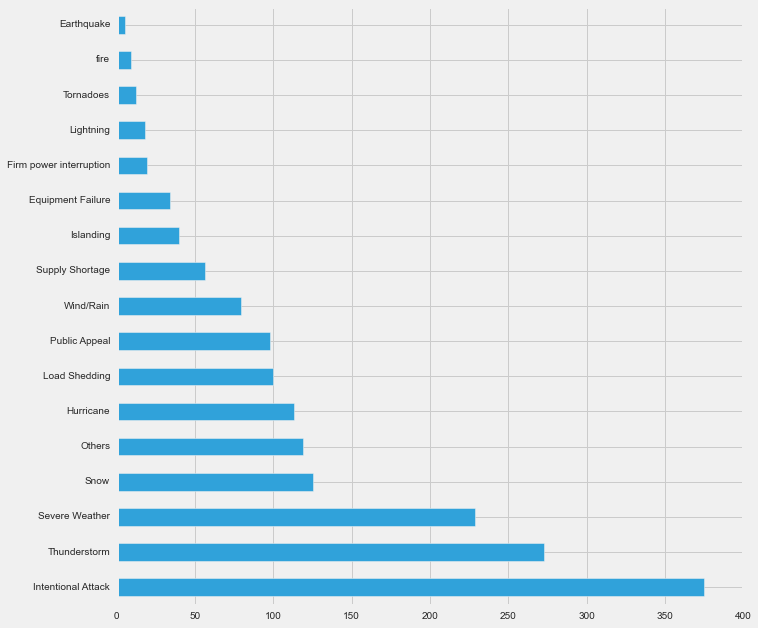

In [106]:
df.cause.value_counts().plot(kind='barh',figsize=(10,10))
plt.savefig('cause.png', bbox_inches='tight')

Intentional attacks form the greatest cause of reported power outages in the United States. This may indicate that the grid is very susceptible to physical attacks and more resources need to be allocated to avoid this. However, the impact of intentional attacks on customers still needs to be observed.

### Intentional Attacks

In [107]:
attacks=df[df.cause=='Intentional Attack']

In [109]:
print "The proportion of blackouts caused by intentional attacks:" + str(round(attacks.shape[0]/float(df.shape[0]),2) * 100) +'%'

The proportion of blackouts caused by intentional attacks:22.0%


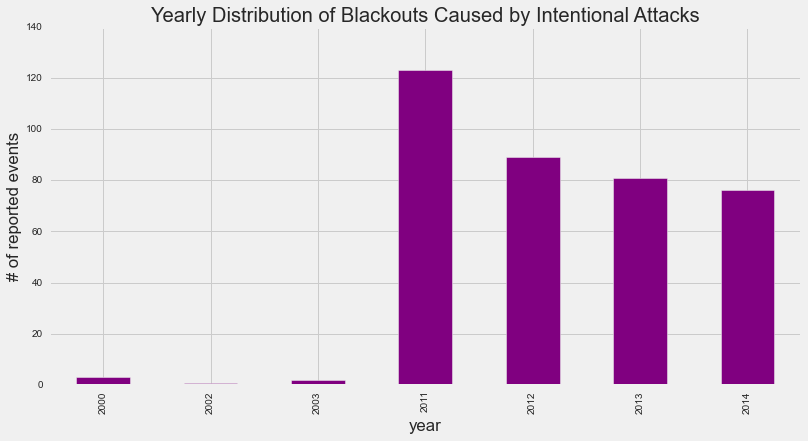

In [110]:
attacks['event_date'].dt.year.value_counts(sort=False).plot(kind='bar',color='purple')
plt.xlabel('year')
plt.ylabel('# of reported events')
plt.title('Yearly Distribution of Blackouts Caused by Intentional Attacks')
plt.savefig('Yearly Intentional Attacks.png',bbox_inches='tight')

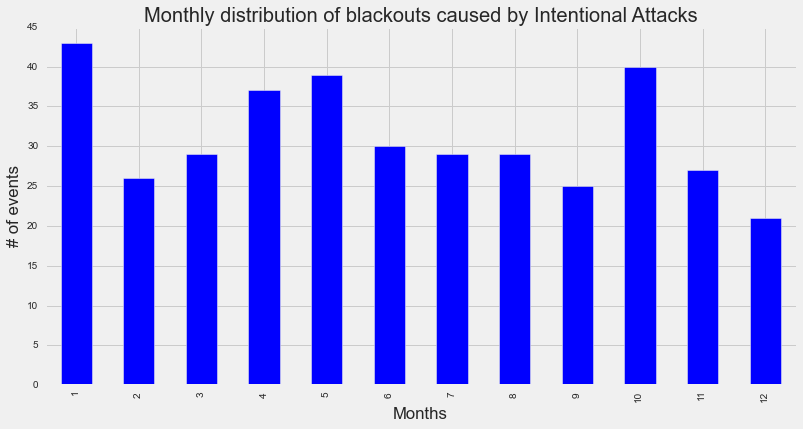

In [111]:
attacks['event_date'].dt.month.value_counts(sort=False).plot(kind='bar',color='blue')
plt.ylabel('# of events')
plt.xlabel('Months')
plt.title('Monthly distribution of blackouts caused by Intentional Attacks')
plt.savefig('Monthly Intentional Attacks.png',bbox_inches='tight')

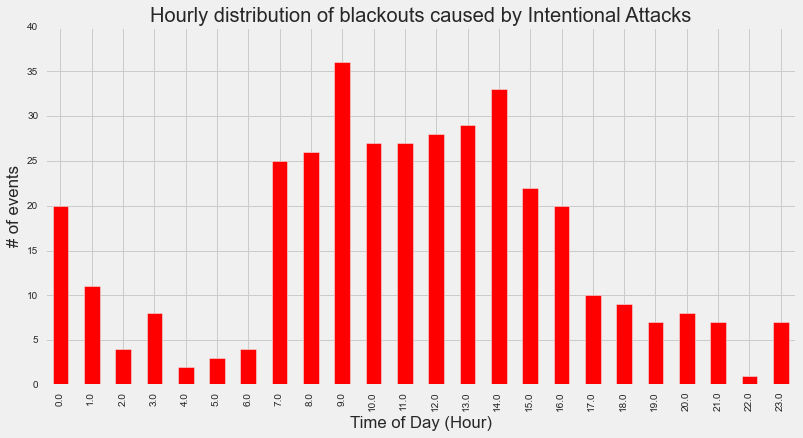

In [112]:
attacks['event_datetime'].dt.hour.value_counts(sort=False).plot(kind='bar',color='red')
plt.ylabel('# of events')
plt.xlabel('Time of Day (Hour)')
plt.title('Hourly distribution of blackouts caused by Intentional Attacks')
plt.savefig('Hourly Intentional Attacks.png',bbox_inches='tight')


### Distribution of blackouts by year and month

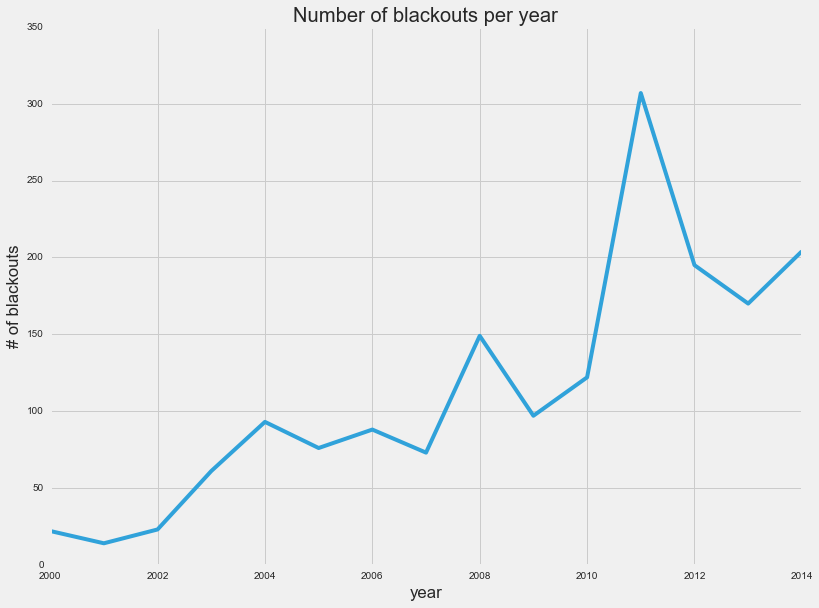

In [114]:
df.event_datetime.dt.year.value_counts(sort=False).plot(figsize=(12,9))
plt.ylabel('# of blackouts')
plt.xlabel('year')
plt.title('Number of blackouts per year')
plt.savefig('blackoutersPerYear.png')

It seems like the number of blackouts reported by utilities is steadily increasing till it reaches its peak in 2011. This is interesting because it may imply that the electricity grid system is getting worse over the years in terms of how it is dealing with blackouts. However, it could also be due to more improved and mandatory reporting of blackouts of different types.

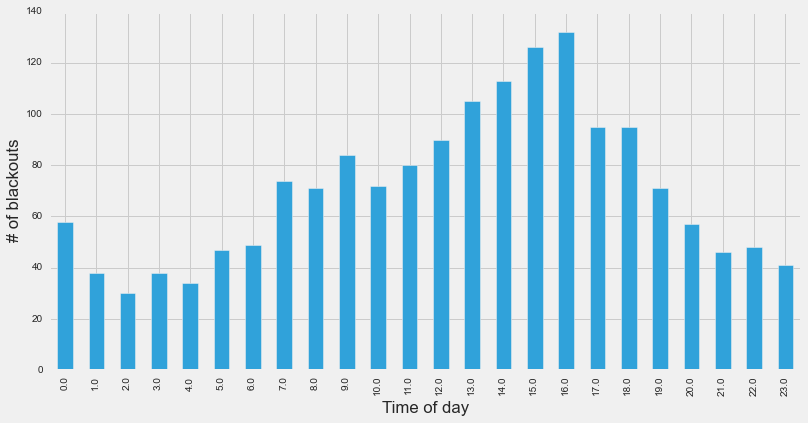

In [115]:
df.event_datetime.dt.hour.value_counts(sort=False).plot(kind='bar')
plt.xlabel('Time of day')
plt.ylabel('# of blackouts')

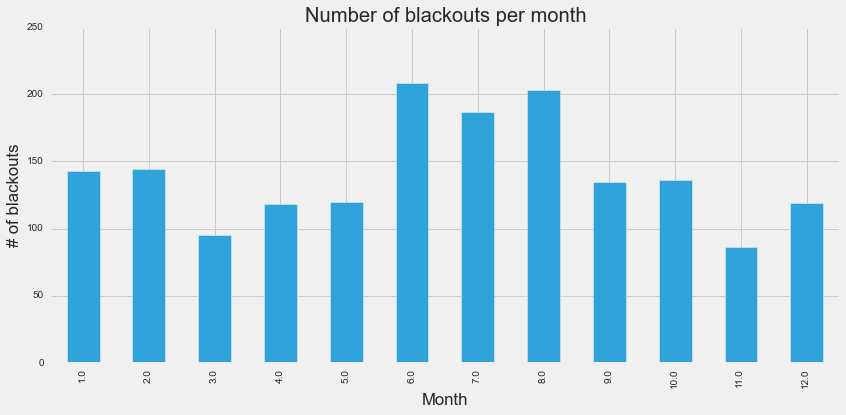

In [116]:
df.event_datetime.dt.month.value_counts(sort=False).plot(kind='bar')
plt.ylabel('# of blackouts')
plt.xlabel('Month')
plt.title('Number of blackouts per month')
plt.tight_layout()

We observe that most of the blackouts reported by utilities occur during the summer months between June and August. One reason for this is likely that hot summer days leads to an increase in usage of air conditioning systems, which further put stress on the grid. 

### Group by the cause of blackout
Now lets categorize what causes each blackout

In [117]:
cause_group=df.groupby('cause')


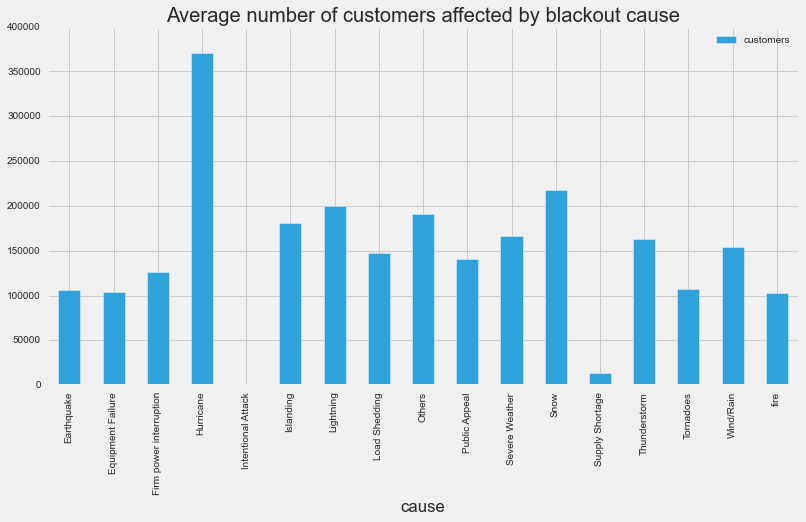

In [118]:
cause_group[['customers']].mean().plot(kind='bar')
#plt.ylabel('Average number of customers')
plt.title('Average number of customers affected by blackout cause')
plt.savefig('meancustomers_cause.png',bbox_inches='tight')

On average, hurricanes affect more customers than anyother cause of blackout

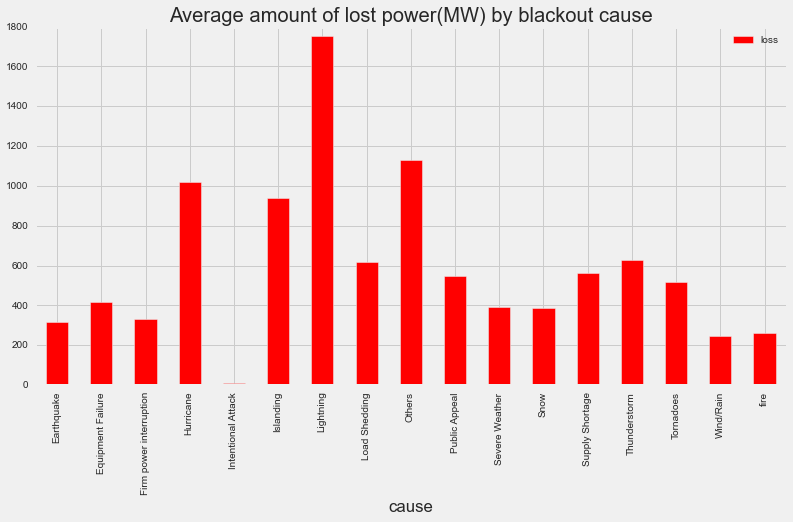

In [119]:
cause_group[['loss']].mean().plot(kind='bar',color='r')
plt.title('Average amount of lost power(MW) by blackout cause')
plt.savefig('meanloss_cause.png',bbox_inches='tight')

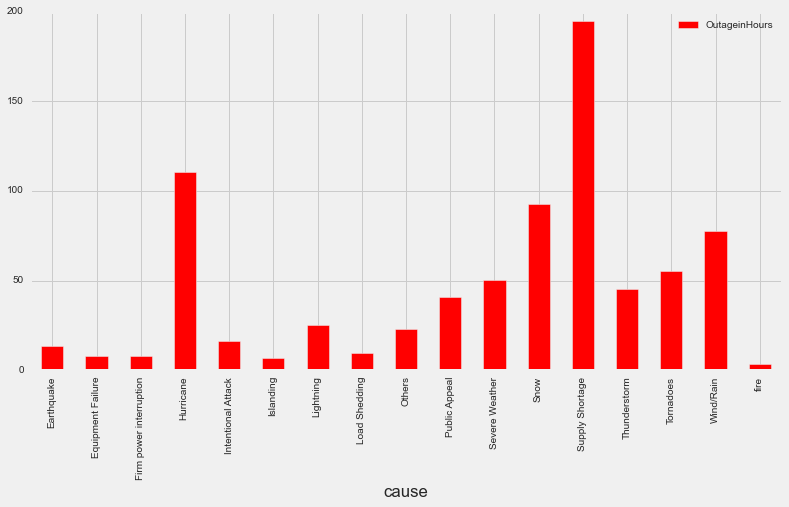

In [120]:
cause_group[['OutageinHours']].mean().plot(kind='bar',color='r')

### Correlation 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f87ba90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f82e290>]], dtype=object)

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


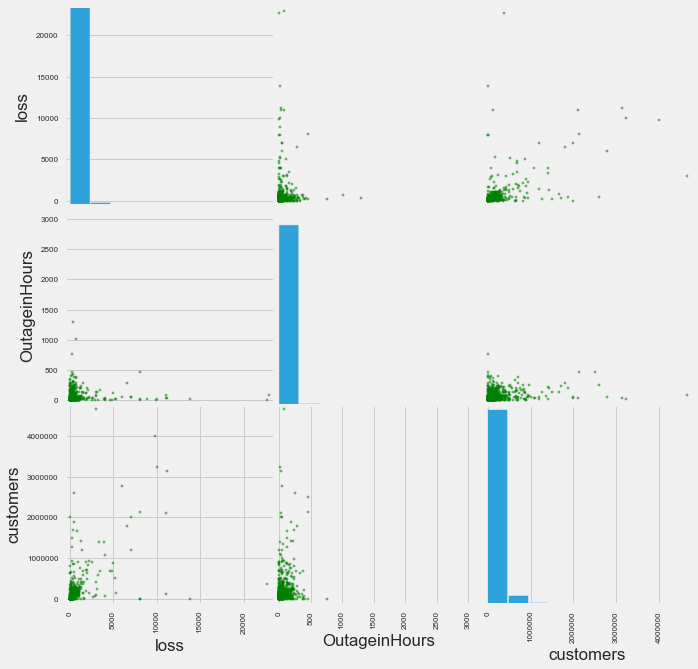

In [122]:
pd.tools.plotting.scatter_matrix(df[['loss','OutageinHours','customers']],figsize=(10,10),color='g')


In [123]:
df_cor=df[['OutageinHours','customers','loss']].corr()
df_cor


,OutageinHours,customers,loss
OutageinHours,1.000000,0.264971,0.055452
customers,0.264971,1.000000,0.512909
loss,0.055452,0.512909,1.000000


Looking at the entire sample, it appears that there's little correlation between the variables. The number of affected customers and loss have the highest correlation.

What would probably be more interesting would be to take a closer look based on the cause of the blackout

### The distribution of days without power

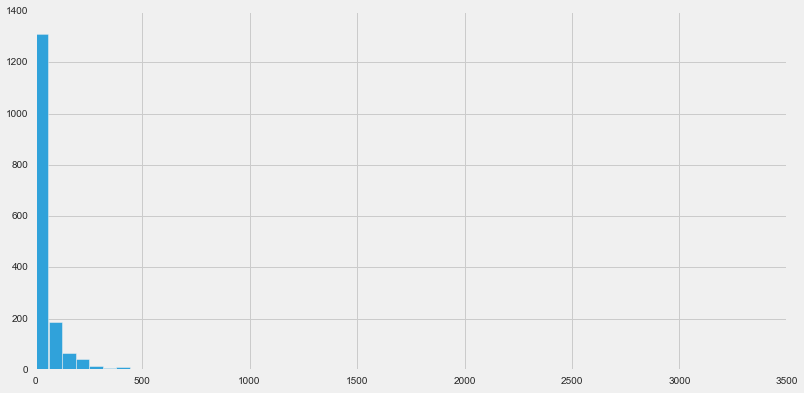

In [127]:
df.OutageinHours.hist(bins=50)

### Relationship between the blackout size and the number of days without power

It seems reasonable that a large blackout will require a long time for power to be restored. The size of the blackout is measured in MW(this is the loss column) and OutageDays is the number of days without power.

In [129]:
df.loss.corr(df.OutageinSeconds)

0.055452246035202844

In [130]:
cause_group_cor=cause_group[['OutageinHours','customers','OutageDays']].corr()

 # below main lower triangle of an array
cause_group_cor= cause_group_cor.stack()
cause_group_cor[(cause_group_cor > 0.35) | (cause_group_cor < -0.35)]


cause                                                
Earthquake               OutageinHours  OutageinHours    1.000000
                                        customers        0.663620
                                        OutageDays       0.965410
                         customers      OutageinHours    0.663620
                                        customers        1.000000
                                        OutageDays       0.614059
                         OutageDays     OutageinHours    0.965410
                                        customers        0.614059
                                        OutageDays       1.000000
Equipment Failure        OutageinHours  OutageinHours    1.000000
                                        OutageDays       0.897949
                         customers      customers        1.000000
                         OutageDays     OutageinHours    0.897949
                                        OutageDays       1.000000
Firm power interruptio

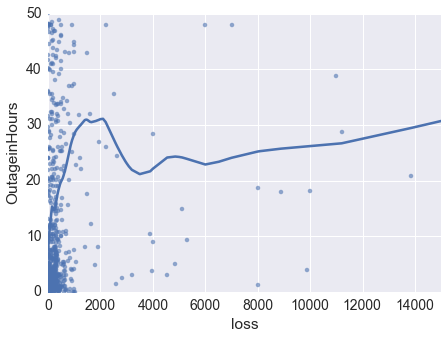

In [131]:
seaborn.set(font_scale=1.4, rc={"lines.linewidth": 1.7}) 
#greater_zero=blackout_data.query('OutageDays>0')
g = seaborn.lmplot("loss", "OutageinHours", x_jitter= .5,  y_jitter= .1,
           data=df,lowess=True, size=5,aspect=1.4, legend_out=False,
           scatter_kws={ 's':20, 'alpha':.6})

g.set(xlim=(0, 15000),ylim=(0, 50))

#g.savefig('1.png',transparent=True)



### Create some new variables

In [132]:
df['loss_sq']=df['loss']**2
df['customer_sq']=df['customers']**2

## Next steps
1. Answer some interesting questions using Machine learning models: For instance, can we predict how long it would take to restore power after a blackout?